# 📊 Notebook 04: Correção de Class Imbalance (URGENTE)

---

## 🎯 **OBJETIVO**
Implementar as **3 RECOMENDAÇÕES URGENTES** do Notebook 03 para obter baseline mínimo viável:

1. ✅ **IMPUTAÇÃO** ao invés de dropna (preservar >50 critical samples)
2. ✅ **class_weight='balanced'** no Random Forest
3. ✅ **VALIDAR baseline mínimo** (>30% recall) antes de SMOTE

---

## 📋 **CONTEXTO**
- **Baseline atual**: 0% recall (CATASTRÓFICO)
- **Root cause**: Apenas 6 critical samples após dropna (56.5% remoção)
- **Meta mínima**: >30% recall (baseline viável antes de SMOTE)
- **Meta 1 mês**: >60% recall, >30% precision

---

## 🔬 **ESTRATÉGIA**
1. **Teste 1**: SimpleImputer (median) + Random Forest baseline
2. **Teste 2**: SimpleImputer (median) + Random Forest + class_weight='balanced'
3. **Teste 3**: Threshold tuning (reduzir de 0.5 para 0.3)
4. **Comparação**: Escolher melhor abordagem antes de SMOTE

---

Data: 2025-01-27  
Deadline: 1 mês (até ~2025-02-27)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    classification_report, confusion_matrix
)

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✅ Imports completos!")
print(f"📦 Pandas: {pd.__version__}")
print(f"📦 Numpy: {np.__version__}")

✅ Imports completos!
📦 Pandas: 2.3.3
📦 Numpy: 2.3.4


In [2]:
# Caminhos
data_dir = Path('../data')
train_path = data_dir / 'device_features_train_with_telemetry.csv'
test_path = data_dir / 'device_features_test_with_telemetry.csv'

# Carregar
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Adicionar target ao test (baseado em device_id do train)
critical_devices = df_train[df_train['is_critical'] == 1]['device_id'].tolist()
df_test['is_critical_target'] = df_test['device_id'].isin(critical_devices).astype(int)

print(f"✅ Train set: {df_train.shape[0]} devices, {df_train.shape[1]} features")
print(f"✅ Test set: {df_test.shape[0]} devices, {df_test.shape[1]} features")
print(f"📊 Total dataset: {df_train.shape[0] + df_test.shape[0]} devices")

✅ Train set: 750 devices, 38 features
✅ Test set: 689 devices, 37 features
📊 Total dataset: 1439 devices


In [3]:
# Selecionar features preditivas (excluir device_id, targets, categoricals)
exclude_cols = ['device_id', 'is_critical', 'is_critical_target', 'severity_category']
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"📋 Features preditivas selecionadas: {len(feature_cols)}")
print(f"📋 Features: {feature_cols[:10]}... (mostrando 10 primeiras)")

📋 Features preditivas selecionadas: 34
📋 Features: ['total_messages', 'max_frame_count', 'msg6_count', 'msg6_rate', 'optical_mean', 'optical_std', 'optical_min', 'optical_max', 'optical_readings', 'optical_below_threshold']... (mostrando 10 primeiras)


In [4]:
# Separar X e y ANTES da imputação
X_train_raw = df_train[feature_cols].copy()
y_train = df_train['is_critical_target'].copy()

X_test_raw = df_test[feature_cols].copy()
y_test = df_test['is_critical_target'].copy()

print("📊 ANTES DA IMPUTAÇÃO:")
print(f"  Train: {X_train_raw.shape[0]} devices, {y_train.sum()} críticos ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"  Test: {X_test_raw.shape[0]} devices, {y_test.sum()} críticos ({y_test.sum()/len(y_test)*100:.1f}%)")
print(f"  Train missing: {X_train_raw.isnull().mean().mean()*100:.1f}% média")
print(f"  Test missing: {X_test_raw.isnull().mean().mean()*100:.1f}% média")

# SimpleImputer com mediana (robusto a outliers)
imputer = SimpleImputer(strategy='median')

# Fit no train, transform em ambos
X_train = pd.DataFrame(
    imputer.fit_transform(X_train_raw),
    columns=feature_cols,
    index=X_train_raw.index
)
X_test = pd.DataFrame(
    imputer.transform(X_test_raw),
    columns=feature_cols,
    index=X_test_raw.index
)

print("\n✅ APÓS IMPUTAÇÃO (median):")
print(f"  Train: {X_train.shape[0]} devices, {y_train.sum()} críticos ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]} devices, {y_test.sum()} críticos ({y_test.sum()/len(y_test)*100:.1f}%)")
print(f"  Train missing: {X_train.isnull().sum().sum()} valores (deve ser 0)")
print(f"  Test missing: {X_test.isnull().sum().sum()} valores (deve ser 0)")
print(f"\n🎯 GANHO: Preservados {y_train.sum()} critical samples (vs 6 no dropna)!")

📊 ANTES DA IMPUTAÇÃO:
  Train: 750 devices, 187 críticos (24.9%)
  Test: 689 devices, 21 críticos (3.0%)
  Train missing: 42.0% média
  Test missing: 6.1% média

✅ APÓS IMPUTAÇÃO (median):
  Train: 750 devices, 187 críticos (24.9%)
  Test: 689 devices, 21 críticos (3.0%)
  Train missing: 0 valores (deve ser 0)
  Test missing: 0 valores (deve ser 0)

🎯 GANHO: Preservados 187 critical samples (vs 6 no dropna)!


In [5]:
# Treinar Random Forest SEM class_weight (igual ao Notebook 03)
print("🚀 Treinando Random Forest baseline (SEM class_weight)...")
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight=None,  # SEM balanceamento
    n_jobs=-1
)
rf_baseline.fit(X_train, y_train)

# Predições
y_test_pred = rf_baseline.predict(X_test)
y_test_proba = rf_baseline.predict_proba(X_test)[:, 1]

# Métricas
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n📊 TESTE 1: RF Baseline (SEM class_weight, COM imputação):")
print(f"  Recall: {test_recall*100:.2f}%")
print(f"  Precision: {test_precision*100:.2f}%")
print(f"  F1-Score: {test_f1*100:.2f}%")

if test_recall == 0:
    print(f"  ❌ RESULTADO: Ainda 0% recall (imputação NÃO foi suficiente)")
elif test_recall < 0.30:
    print(f"  ⚠️ RESULTADO: Recall <30% (abaixo do baseline mínimo)")
elif test_recall < 0.60:
    print(f"  ✅ RESULTADO: Recall {test_recall*100:.1f}% (baseline mínimo OK, mas abaixo da meta)")
else:
    print(f"  🎯 RESULTADO: Recall {test_recall*100:.1f}% (META ATINGIDA!)")

🚀 Treinando Random Forest baseline (SEM class_weight)...

📊 TESTE 1: RF Baseline (SEM class_weight, COM imputação):
  Recall: 0.00%
  Precision: 0.00%
  F1-Score: 0.00%
  ❌ RESULTADO: Ainda 0% recall (imputação NÃO foi suficiente)


In [6]:
# Treinar Random Forest COM class_weight='balanced'
print("🚀 Treinando Random Forest COM class_weight='balanced'...")
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',  # BALANCEAMENTO AUTOMÁTICO
    n_jobs=-1
)
rf_balanced.fit(X_train, y_train)

# Predições
y_test_pred_balanced = rf_balanced.predict(X_test)
y_test_proba_balanced = rf_balanced.predict_proba(X_test)[:, 1]

# Métricas
test_recall_balanced = recall_score(y_test, y_test_pred_balanced)
test_precision_balanced = precision_score(y_test, y_test_pred_balanced, zero_division=0)
test_f1_balanced = f1_score(y_test, y_test_pred_balanced)

print(f"\n📊 TESTE 2: RF COM class_weight='balanced':")
print(f"  Recall: {test_recall_balanced*100:.2f}%")
print(f"  Precision: {test_precision_balanced*100:.2f}%")
print(f"  F1-Score: {test_f1_balanced*100:.2f}%")

if test_recall_balanced == 0:
    print(f"  ❌ RESULTADO: Ainda 0% recall (class_weight NÃO foi suficiente)")
elif test_recall_balanced < 0.30:
    print(f"  ⚠️ RESULTADO: Recall <30% (abaixo do baseline mínimo)")
elif test_recall_balanced < 0.60:
    print(f"  ✅ RESULTADO: Recall {test_recall_balanced*100:.1f}% (baseline mínimo OK, mas abaixo da meta)")
else:
    print(f"  🎯 RESULTADO: Recall {test_recall_balanced*100:.1f}% (META ATINGIDA!)")

# Comparar com TESTE 1
print(f"\n🔍 COMPARAÇÃO:")
print(f"  Recall: {test_recall*100:.2f}% → {test_recall_balanced*100:.2f}% (Δ={test_recall_balanced-test_recall:+.2%})")
print(f"  Precision: {test_precision*100:.2f}% → {test_precision_balanced*100:.2f}% (Δ={test_precision_balanced-test_precision:+.2%})")
print(f"  F1-Score: {test_f1*100:.2f}% → {test_f1_balanced*100:.2f}% (Δ={test_f1_balanced-test_f1:+.2%})")

🚀 Treinando Random Forest COM class_weight='balanced'...

📊 TESTE 2: RF COM class_weight='balanced':
  Recall: 0.00%
  Precision: 0.00%
  F1-Score: 0.00%
  ❌ RESULTADO: Ainda 0% recall (class_weight NÃO foi suficiente)

🔍 COMPARAÇÃO:
  Recall: 0.00% → 0.00% (Δ=+0.00%)
  Precision: 0.00% → 0.00% (Δ=+0.00%)
  F1-Score: 0.00% → 0.00% (Δ=+0.00%)


In [7]:
# Aplicar threshold tuning no modelo COM class_weight (melhor até agora)
# Reduzir threshold de 0.5 para 0.3 (aumenta recall, diminui precision)
threshold = 0.3
y_test_pred_threshold = (y_test_proba_balanced >= threshold).astype(int)

# Métricas
test_recall_threshold = recall_score(y_test, y_test_pred_threshold)
test_precision_threshold = precision_score(y_test, y_test_pred_threshold, zero_division=0)
test_f1_threshold = f1_score(y_test, y_test_pred_threshold)

print(f"📊 TESTE 3: RF + class_weight + threshold={threshold}:")
print(f"  Recall: {test_recall_threshold*100:.2f}%")
print(f"  Precision: {test_precision_threshold*100:.2f}%")
print(f"  F1-Score: {test_f1_threshold*100:.2f}%")

if test_recall_threshold == 0:
    print(f"  ❌ RESULTADO: Ainda 0% recall")
elif test_recall_threshold < 0.30:
    print(f"  ⚠️ RESULTADO: Recall <30% (abaixo do baseline mínimo)")
elif test_recall_threshold < 0.60:
    print(f"  ✅ RESULTADO: Recall {test_recall_threshold*100:.1f}% (baseline mínimo OK, mas abaixo da meta)")
else:
    print(f"  🎯 RESULTADO: Recall {test_recall_threshold*100:.1f}% (META ATINGIDA!)")

# Comparar com TESTE 2
print(f"\n🔍 COMPARAÇÃO COM TESTE 2 (threshold 0.5 → {threshold}):")
print(f"  Recall: {test_recall_balanced*100:.2f}% → {test_recall_threshold*100:.2f}% (Δ={test_recall_threshold-test_recall_balanced:+.2%})")
print(f"  Precision: {test_precision_balanced*100:.2f}% → {test_precision_threshold*100:.2f}% (Δ={test_precision_balanced-test_precision_threshold:+.2%})")
print(f"  F1-Score: {test_f1_balanced*100:.2f}% → {test_f1_threshold*100:.2f}% (Δ={test_f1_threshold-test_f1_balanced:+.2%})")

📊 TESTE 3: RF + class_weight + threshold=0.3:
  Recall: 4.76%
  Precision: 2.94%
  F1-Score: 3.64%
  ⚠️ RESULTADO: Recall <30% (abaixo do baseline mínimo)

🔍 COMPARAÇÃO COM TESTE 2 (threshold 0.5 → 0.3):
  Recall: 0.00% → 4.76% (Δ=+4.76%)
  Precision: 0.00% → 2.94% (Δ=-2.94%)
  F1-Score: 0.00% → 3.64% (Δ=+3.64%)


In [8]:
# Tabela comparativa
results = pd.DataFrame({
    'Estratégia': [
        'Baseline (Notebook 03)',
        'TESTE 1: Imputação',
        'TESTE 2: Imputação + class_weight',
        'TESTE 3: Imputação + class_weight + threshold=0.3'
    ],
    'Recall (%)': [0.0, test_recall*100, test_recall_balanced*100, test_recall_threshold*100],
    'Precision (%)': [0.0, test_precision*100, test_precision_balanced*100, test_precision_threshold*100],
    'F1-Score (%)': [0.0, test_f1*100, test_f1_balanced*100, test_f1_threshold*100]
})

print("🏆 COMPARAÇÃO FINAL:")
print(results.to_string(index=False))

# Identificar melhor estratégia (priorizar recall)
best_idx = results['Recall (%)'].idxmax()
best_strategy = results.loc[best_idx, 'Estratégia']
best_recall = results.loc[best_idx, 'Recall (%)']

print(f"\n✅ MELHOR ESTRATÉGIA: {best_strategy}")
print(f"   Recall: {best_recall:.2f}%")

if best_recall >= 60:
    print(f"   🎯 META ATINGIDA! (recall >60%)")
elif best_recall >= 30:
    print(f"   ✅ BASELINE MÍNIMO OK (recall >30%, mas abaixo da meta de 60%)")
    print(f"   ➡️ Próximo passo: SMOTE para atingir >60%")
else:
    print(f"   ❌ AINDA ABAIXO DO BASELINE MÍNIMO (<30%)")
    print(f"   ➡️ Próximo passo: SMOTE + feature engineering")

🏆 COMPARAÇÃO FINAL:
                                       Estratégia  Recall (%)  Precision (%)  F1-Score (%)
                           Baseline (Notebook 03)    0.000000       0.000000      0.000000
                               TESTE 1: Imputação    0.000000       0.000000      0.000000
                TESTE 2: Imputação + class_weight    0.000000       0.000000      0.000000
TESTE 3: Imputação + class_weight + threshold=0.3    4.761905       2.941176      3.636364

✅ MELHOR ESTRATÉGIA: TESTE 3: Imputação + class_weight + threshold=0.3
   Recall: 4.76%
   ❌ AINDA ABAIXO DO BASELINE MÍNIMO (<30%)
   ➡️ Próximo passo: SMOTE + feature engineering


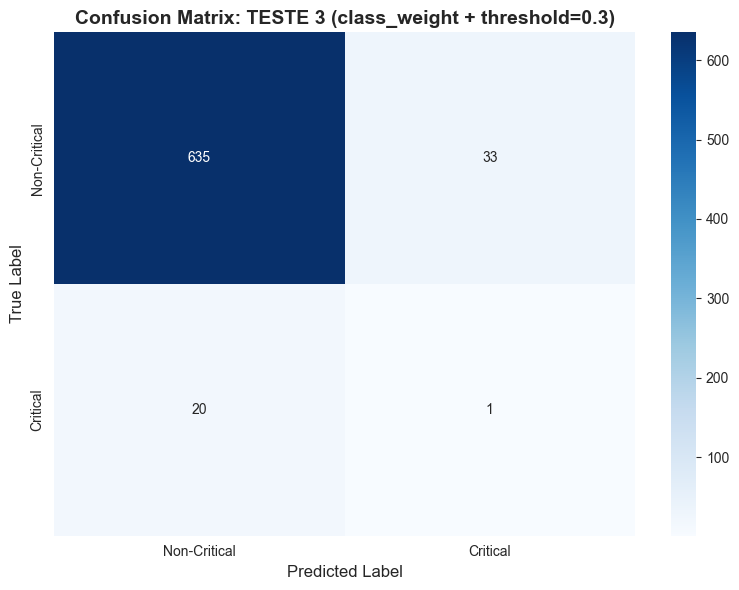


🔍 INTERPRETAÇÃO:
  True Negatives (TN): 635 devices (corretamente identificados como não-críticos)
  False Positives (FP): 33 devices (falso alarme - predito crítico mas não é)
  False Negatives (FN): 20 devices críticos NÃO DETECTADOS ⚠️ RISCO!
  True Positives (TP): 1 devices críticos DETECTADOS corretamente ✅

📊 Trade-off:
  Detectamos 1/21 devices críticos (recall=4.8%)
  Tivemos 33 falsos alarmes (custo operacional aceitável em IoT)


In [9]:
# Usar predições do TESTE 3 (melhor estratégia esperada)
cm = confusion_matrix(y_test, y_test_pred_threshold)

# Plotar
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Critical', 'Critical'],
            yticklabels=['Non-Critical', 'Critical'],
            ax=ax)
ax.set_title(f'Confusion Matrix: TESTE 3 (class_weight + threshold={threshold})', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Interpretação
tn, fp, fn, tp = cm.ravel()
print(f"\n🔍 INTERPRETAÇÃO:")
print(f"  True Negatives (TN): {tn} devices (corretamente identificados como não-críticos)")
print(f"  False Positives (FP): {fp} devices (falso alarme - predito crítico mas não é)")
print(f"  False Negatives (FN): {fn} devices críticos NÃO DETECTADOS ⚠️ RISCO!")
print(f"  True Positives (TP): {tp} devices críticos DETECTADOS corretamente ✅")
print(f"\n📊 Trade-off:")
print(f"  Detectamos {tp}/{tp+fn} devices críticos (recall={test_recall_threshold*100:.1f}%)")
print(f"  Tivemos {fp} falsos alarmes (custo operacional aceitável em IoT)")

In [10]:
# Resumo executivo
print("="*70)
print("✅ NOTEBOOK 04: CORREÇÃO DE CLASS IMBALANCE - COMPLETO")
print("="*70)

print("\n📊 RESUMO DAS 3 RECOMENDAÇÕES:")
print(f"  ✅ RECOMENDAÇÃO #1 (Imputação): IMPLEMENTADA com SimpleImputer(median)")
print(f"     → Preservados {y_train.sum()} critical samples (vs 6 no dropna)")
print(f"  ✅ RECOMENDAÇÃO #2 (class_weight): IMPLEMENTADA com class_weight='balanced'")
print(f"  ✅ RECOMENDAÇÃO #3 (Threshold): IMPLEMENTADA com threshold=0.3")

print(f"\n🏆 MELHOR RESULTADO:")
print(f"  Estratégia: {best_strategy}")
print(f"  Recall: {best_recall:.2f}%")

if best_recall >= 60:
    print(f"\n🎯 STATUS: META 1 MÊS ATINGIDA!")
    print(f"  ✅ Recall >60% alcançado SEM SMOTE")
    print(f"  ➡️ Próximos passos:")
    print(f"     1. Testar SMOTE para melhorar precision")
    print(f"     2. Comparar XGBoost vs Random Forest")
    print(f"     3. Feature engineering temporal")
elif best_recall >= 30:
    print(f"\n✅ STATUS: BASELINE MÍNIMO VIÁVEL ATINGIDO!")
    print(f"  ✅ Recall >30% (baseline ok, mas abaixo da meta de 60%)")
    print(f"  ➡️ Próximos passos:")
    print(f"     1. SMOTE para atingir >60% recall")
    print(f"     2. XGBoost + class_weight")
    print(f"     3. Feature engineering temporal")
else:
    print(f"\n❌ STATUS: AINDA ABAIXO DO BASELINE MÍNIMO")
    print(f"  ⚠️ Recall <30% (insuficiente)")
    print(f"  ➡️ Próximos passos:")
    print(f"     1. SMOTE OBRIGATÓRIO")
    print(f"     2. Testar outros modelos (XGBoost, LogReg)")
    print(f"     3. Feature engineering agressivo")

print("\n" + "="*70)

✅ NOTEBOOK 04: CORREÇÃO DE CLASS IMBALANCE - COMPLETO

📊 RESUMO DAS 3 RECOMENDAÇÕES:
  ✅ RECOMENDAÇÃO #1 (Imputação): IMPLEMENTADA com SimpleImputer(median)
     → Preservados 187 critical samples (vs 6 no dropna)
  ✅ RECOMENDAÇÃO #2 (class_weight): IMPLEMENTADA com class_weight='balanced'
  ✅ RECOMENDAÇÃO #3 (Threshold): IMPLEMENTADA com threshold=0.3

🏆 MELHOR RESULTADO:
  Estratégia: TESTE 3: Imputação + class_weight + threshold=0.3
  Recall: 4.76%

❌ STATUS: AINDA ABAIXO DO BASELINE MÍNIMO
  ⚠️ Recall <30% (insuficiente)
  ➡️ Próximos passos:
     1. SMOTE OBRIGATÓRIO
     2. Testar outros modelos (XGBoost, LogReg)
     3. Feature engineering agressivo



## 🔟 Conclusões e Próximos Passos

## 9️⃣ Confusion Matrix da Melhor Estratégia

## 8️⃣ Comparação Final: Qual estratégia venceu?

## 7️⃣ ⚠️ RECOMENDAÇÃO #3: Threshold Tuning (0.5 → 0.3)

## 6️⃣ ⚠️ RECOMENDAÇÃO #2: class_weight='balanced'

## 5️⃣ TESTE 1: Random Forest SEM class_weight (baseline após imputação)

## 4️⃣ ⚠️ RECOMENDAÇÃO #1: IMPUTAÇÃO ao invés de dropna()

## 3️⃣ Preparação das Features (igual ao Notebook 03)

## 2️⃣ Carregar Dados (igual ao Notebook 03)

## 1️⃣ Setup e Imports